In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kr_helper_funcs as kr
from sklearn.preprocessing import MinMaxScaler
import kr_helper_funcs as kr
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from lime import lime_tabular
import shap
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
name = 'with_postcode'
fileName = "{}/lending-club-values.csv".format(name)
model = tf.keras.models.load_model('{}/lending-club.h5'.format(name), custom_objects={"f1": kr.f1})
X_train_unscaled = np.load("{}/X_train_unscaled.npy".format(name))
X_test_unscaled = np.load("{}/X_test_unscaled.npy".format(name))
y_train = np.load("{}/y_test.npy".format(name))
y_test = np.load("{}/y_test.npy".format(name))
df = pd.read_csv('{}/lending-club-df.csv'.format(name))
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

prev_scaled_row = None
cached_map_values = None
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

res = pd.read_csv(fileName)

In [3]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies', 'loan_repaid', 'A2', 'A3', 'A4',
       'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1',
       'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3',
       'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_INDIVIDUAL', 'application_type_JOINT',
       'initial_list_status_w', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'OTHER', 'OWN', 'RENT', '05113',
       '11650', '22690', '29597', '

In [4]:
df.corr()["loan_amnt"].sort_values(ascending=False)

loan_amnt               1.000000
installment             0.953872
term                    0.393731
annual_inc              0.337364
revol_bal               0.328515
                          ...   
pub_rec                -0.078143
pub_rec_bankruptcies   -0.106669
purpose_other          -0.127022
earliest_cr_year       -0.147380
RENT                   -0.174397
Name: loan_amnt, Length: 79, dtype: float64

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0.3033678256734856, 0.2659884746529759, 0.2629855944138134, 0.2619886934882597, 0.26104094077779755, 0.2602115195942008, 0.2600928169631709, 0.25922756391093976, 0.25908510195847945, 0.2588668265723141, 0.2585677348704944, 0.2585758605447882, 0.25815346045259185, 0.2581877837261589, 0.2577265787222663, 0.2574411345800694, 0.2573622149989248, 0.25708948292543343, 0.257033827036909, 0.2566258766798763, 0.2567821976789196, 0.25644192630178403, 0.25622074167662634, 0.2562266084279167, 0.25598109938645536]


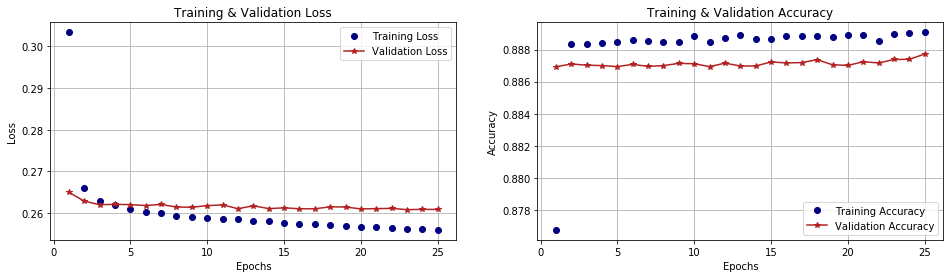

In [5]:
history = pd.read_csv('{}/lending-club-history.csv'.format(name))
history_dict = history.to_dict('list')
kr.show_plots(history_dict)

In [6]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.97      0.45      0.61     15658
           1       0.88      1.00      0.93     63386

    accuracy                           0.89     79044
   macro avg       0.92      0.72      0.77     79044
weighted avg       0.90      0.89      0.87     79044



[[ 7012  8646]
 [  229 63157]]


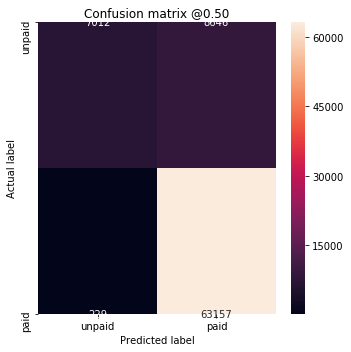

In [7]:
kr.plot_cm(y_test, predictions, ["unpaid", "paid"])

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(),annot=True,cmap='viridis', linewidth=1)
plt.ylim(33, 0)


(33, 0)

In [ ]:
def plot_roc(name, labels, predictions, ax, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    lw = 2
    plt.plot(fp, tp, color='darkorange',
             lw=lw, label='ROC curve '+ name, **kwargs)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
def plot_model_results(model):
    fig, (f1, f2, f3, f4) =plt.subplots(1,4, figsize=(25,6))
    predictions = model.predict_classes(X_test)
    report = classification_report(y_test,predictions)
    print(report)
    report_json = classification_report(y_test,predictions, output_dict=True)
#     save_report_to_latex(model_name, report_json)
    
    
    losses = pd.DataFrame(history)
    fig1 = losses[['loss','val_loss']].plot(ax=f1) 
    fig1.set_ylabel('Cost')
    fig1.set_xlabel('Epochs')
    
    cm = confusion_matrix(y_test,predictions > 0.5)
    fig2= sns.heatmap(cm, annot=True, fmt="d", ax=f2)
    fig2.set_title('Confusion matrix @{:.2f}'.format(0.5))
    fig2.set_ylabel('Actual label')
    fig2.set_xlabel('Predicted label')
    fig2.set_ylim(2, 0)

    fig3 = plot_roc("Train Baseline",y_train, model.predict_classes(X_train[:len(X_test)]) , ax=f4)
    fig3 = plot_roc("Test Baseline", y_test, model.predict_classes(X_test), ax=f4, linestyle='--')
    
    fig4 = losses[['accuracy','val_accuracy']].plot(ax=f3) 
    fig4.set_ylabel('Accuracy')
    fig4.set_xlabel('Epochs')
#     save('/building_ann/' + model_name + '.png')
    plt.show()
plot_model_results(model)

In [ ]:
len(X_test)

In [ ]:
res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random')].head()


In [ ]:
sns.countplot(x="explainer",data=res[(res['nsamples'] == 'auto') ], hue = 'class_change')
plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

In [ ]:
res.count()

In [ ]:
df.columns

In [ ]:
def get_countplot(explainer):
    columns = df.drop('loan_repaid', axis=1).columns
    result = res[(res['nsamples'] == 'auto') & (res['explainer'] == explainer) & (res["reverse_order"] == reverse_order)].drop(['original_probability',"new_probability", "confidence_diff", "original_class", "class_change","no_features","nsamples","explainer","time","reverse_order"],axis=1)
    result.columns = [''] * len(result.columns)
    result = result.dropna()
    flat_list = pd.DataFrame([columns[int(item)] for sublist in result.values.tolist() for item in sublist])
    return flat_list

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(35, 20))
reverse_order = False
plt.figure(figsize=(25,4))

countplot_list = get_countplot("shap")
ax[0][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][0])
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=40, ha="right")
ax[0][0].set_title("Shap - Contplot across all feature importances")

countplot_list = get_countplot("lime")
ax[0][1] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][1])
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=40, ha="right")
ax[0][1].set_title("Lime - Contplot across all feature importances")

countplot_list = get_countplot("eli5")
ax[1][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=40, ha="right")
ax[1][0].set_title("Eli5 - Contplot across all feature importances")

countplot_list = get_countplot("random")
ax[1][1] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][1])
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=40, ha="right")
ax[1][1].set_title("Random - Contplot across all feature importances")

In [ ]:
result = res[(res['nsamples'] == 'auto') & (res['explainer'] == "shap") & (res["reverse_order"] == reverse_order)].drop(['original_probability',"new_probability", "confidence_diff", "original_class", "class_change","no_features","nsamples","explainer","time","reverse_order"],axis=1)
result.columns = [''] * len(result.columns)
result = result.dropna()
flat_list = pd.DataFrame([df.columns[int(item)] for sublist in result.values.tolist() for item in sublist])
# pd.DataFrame([df.columns[item] for item in flat_list])
flat_list

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))

data = res[(res['nsamples'] == 'auto') & (res["reverse_order"] == False)]

ax[0]=sns.countplot(x="no_features",data=data[data['explainer'] == 'shap'], hue = 'class_change', ax = ax[0])
ax[0].set_title("Shap - Distribution of class changes based on the number of features eliminated")

ax[1]=sns.countplot(x="no_features",data=data[data['explainer'] == 'lime'], hue = 'class_change', ax = ax[1])
ax[1].set_title("Lime")

ax[2]=sns.countplot(x="no_features",data=data[data['explainer'] == 'eli5'], hue = 'class_change', ax = ax[2])
ax[2].set_title("Eli5")

ax[3]=sns.countplot(x="no_features",data=data[data['explainer'] == 'random'], hue = 'class_change', ax = ax[3])
ax[3].set_title("Random")

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, reverse_order ):
    data = res[(res['nsamples'] == 'auto') & (res["reverse_order"] == reverse_order)]
    return data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].mean()

reverse_order = False
no_of_features = list(range(0, len(get_data("random", False)) ))
ax[0].plot( no_of_features,  get_data("random", reverse_order), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", reverse_order) , color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", reverse_order) , color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", reverse_order) , color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
ax[0].set_title("Average of confidence level change vs no of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase")
ax[0].legend(loc='best')

reverse_order = True
no_of_features = list(range(0, len(get_data("random", reverse_order)) ))
ax[1].plot( no_of_features, get_data("random", reverse_order), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", reverse_order), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features,get_data("lime", reverse_order), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", reverse_order), color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
# ax[1].set_title("Average of confidence level change vs no of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase")
ax[1].legend(loc='best')

In [ ]:
res[(res['nsamples'] == 'auto') ].groupby("no_features")["confidence_diff"].mean() 

In [ ]:
# Same as the graph above but the plot is class specific, in this case for class 1. For class 0, there are not enough datapoints to plot the graph
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, reverse_order ):
    data = res[(res['nsamples'] == 'auto') & (res["reverse_order"] == reverse_order)]
    return data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].mean()

original_class = 1
avg_random = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random') & (res['original_class'] == original_class) & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean() 
avg_shap = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'shap') & (res['original_class'] == original_class) & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()
avg_lime = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'lime') & (res['original_class'] == original_class)  & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()
avg_eli5 = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'eli5') & (res['original_class'] == original_class)  & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()

plt.figure(figsize=(11,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_random) ))
ax[0].plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, avg_shap, color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, avg_lime, color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, avg_eli5, color='yellow', marker='o', linestyle='-', label='Eli5')
ax[0].legend(loc='best')

original_class = 0
avg_random = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random') & (res['original_class'] == original_class) & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean() 
avg_shap = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'shap') & (res['original_class'] == original_class) & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()
avg_lime = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'lime') & (res['original_class'] == original_class)  & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()
avg_eli5 = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'eli5') & (res['original_class'] == original_class)  & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()

plt.figure(figsize=(11,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_random) ))
ax[1].plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, avg_shap, color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features, avg_lime, color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, avg_eli5, color='yellow', marker='o', linestyle='-', label='Eli5')
ax[1].legend(loc='best')

In [ ]:
# Same as the graph above but the plot is class specific, in this case for class 1. For class 0, there are not enough datapoints to plot the graph
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, original_class):
    default_data = res[(res['nsamples'] == 'auto') & (res["reverse_order"] == False)]
    return default_data[(default_data['explainer'] == explainer) & (default_data['original_class'] == original_class)].groupby("no_features")["confidence_diff"].mean()

original_class = 1
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(avg_random) ))
ax[0].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[0].set_title("Class {}".format(original_class))
ax[0].legend(loc='best')

original_class = 0
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(avg_random) ))
ax[1].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[1].set_title("Class {}".format(original_class))
ax[1].legend(loc='best')

In [ ]:
res[res["original_class"] == 0].head(5)

In [ ]:
def get_data(explainer, reverse_order):
    data = res[(res['nsamples'] == 'auto') & (res["reverse_order"] == reverse_order)] 
    data_count = data[(res['confidence_diff'] < 0.01)]
    return data_count[data_count['explainer'] == explainer].groupby("no_features")["confidence_diff"].count() / data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].count()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

reverse_order = False
no_of_features = list(range(0, len(get_data("random", reverse_order)) ))
ax[0].plot( no_of_features, get_data("random", reverse_order), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("shap", reverse_order), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("lime", reverse_order), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("eli5", reverse_order), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
ax[0].set_title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
ax[0].legend(loc='best')

reverse_order = True
no_of_features = list(range(0, len(get_data("random", reverse_order)) ))
ax[1].plot( no_of_features, get_data("random", reverse_order), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("shap", reverse_order), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("lime", reverse_order), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("eli5", reverse_order), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
ax[1].set_title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
ax[1].legend(loc='best')

In [ ]:
def get_data(explainer):
    data = res[res['nsamples'] == 'auto']
    data_count = data[(res['confidence_diff'] < 0.01)]
    return data_count[data_count['explainer'] == explainer].groupby("no_features")["confidence_diff"].count() / data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].count()

plt.figure(figsize=(10,4))
no_of_features = list(range(0, len(get_data("shap")) ))
plt.plot( no_of_features, get_data("random"), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
plt.plot( no_of_features, get_data("shap"), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
plt.plot( no_of_features, get_data("lime"), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
plt.plot( no_of_features, get_data("eli5"), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
plt.title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
plt.legend(loc='best')

In [ ]:

# avg_random = res[(res["no_features"]==0) & (res['explainer'] == 'random')].groupby("nsamples")["time"].mean() 
avg_shap = res[(res["no_features"]==0) & (res['explainer'] == 'shap')].groupby("nsamples")["time"].mean()
avg_lime = res[(res["no_features"]==0) & (res['explainer'] == 'lime')].groupby("nsamples")["time"].mean()

plt.figure(figsize=(10,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_shap)))
# plt.plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
plt.plot( no_of_features, avg_shap, color='green', marker='x', linestyle='-', label='Shap')
plt.plot( no_of_features, avg_lime, color='red', marker='o', linestyle='-', label='Lime')
plt.title("Average time taken for each explainer to compute top 30 most important features of a row based on the nsamples allowed to compute")
plt.legend(loc='best')

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

def base_model():       
    return model
# X_train_unscaled, X_test_unscaled, y_train, y_test
# train_x, val_x, train_y, val_y
my_model = KerasRegressor(build_fn=base_model)    
my_model.fit(X_test, y_test)

perm = PermutationImportance(my_model).fit(X_test[0:1000],y_test[0:1000])
eli5.show_weights(perm, feature_names = list(df.drop('loan_repaid', axis=1).columns))

In [ ]:
l = list(range(17))
n = 5
midpoint = int(len(l)/2)
start_middle = midpoint-int(n/2)
print(l)
l[start_middle:start_middle+n]

In [ ]:
# eli5.show_prediction(model, X_test[row_number].reshape(1, X_test.shape[1]))

In [ ]:
# https://slundberg.github.io/shap/notebooks/plots/decision_plot.html -- types of plots available for shap
import shap
def predict_fn(x):
    preds = model.predict(x).reshape(-1, 1)
    p0 = 1 - preds
    return np.hstack((p0, preds))
row_number=2
explainer_shap = shap.KernelExplainer(model.predict, X_train[0:1000])
shap_values = explainer_shap.shap_values(X_test[row_number].reshape(1, X_test.shape[1]), nsamples="auto", l1_reg="num_features(30)")

shap.decision_plot(explainer_shap.expected_value[0], shap_values[0][0, :], X_test[row_number], feature_names=list(df.drop('loan_repaid', axis=1).columns), link="logit")

In [ ]:
shap.initjs()
shap.force_plot(explainer_shap.expected_value[0], shap_values[0][0, :], X_test[row_number], feature_names=list(df.drop('loan_repaid', axis=1).columns), link="logit")

In [ ]:
shap.initjs()
shap.force_plot(explainer_shap.expected_value[0], shap_values[0][0, :], X_test[row_number], feature_names=list(df.drop('loan_repaid', axis=1).columns), link="logit")

In [ ]:
columns = list(df.drop('loan_repaid', axis=1).columns)
explainer_lime = lime_tabular.LimeTabularExplainer(X_train, class_names=list(['Charged off', 'Fully paid']), feature_names= list(df.drop('loan_repaid', axis=1).columns))
exp = explainer_lime.explain_instance(X_test[row_number], model.predict, num_features=30, top_labels=30)  
exp.show_in_notebook(show_table=True, show_all=False)
model.predict()

In [ ]:
help(shap.KernelExplainer)

In [ ]:
df.drop('loan_repaid', axis=1).columns

In [ ]:
X_test[row_number]

In [ ]:
# %tensorboard --logdir "logs\\hparam_tuning\\2020-07-04-2313" --host localhost --port 8080

In [ ]:
explainer_shap.expected_value

In [ ]:
class_avg_1 = [a for a in y_test if a  ==1]
sum(class_avg_1)/len(y_train)
# class_avg_1
model.predict(X_test[row_number].reshape(1, X_test.shape[1]))

In [ ]:
global_shap_values = explainer_shap.shap_values(X_test[0:10])
shap.summary_plot(global_shap_values, X_test[0:10])

In [ ]:
help(shap.summary_plot)

In [ ]:
shap.summary_plot(global_shap_values, X_test[0:10], plot_type="bar", feature_names=list(df.drop('loan_repaid', axis=1).columns))

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir "ray_results\\create_model_tune_cofig" 

In [ ]:
import os
path="/home/dan393/ray_results_f/create_model_tune_cofig"
os.chdir(path)
for file in os.listdir():
    if os.path.isdir(file):
        split_words = file.split("_")
        os.rename(file, "create_model_tune_cofig_{}_{}".format(split_words[4], split_words[len(split_words)-1]))